In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('onedork')

<img src=https://desafiolatam.com/assets/home/logo-academia-bla-790873cdf66b0e681dfbe640ace8a602f5330bec301c409744c358330e823ae3.png>

# Proyecto Data Science
#### Predicción sobre la aprobación de leyes en el congreso chileno

    * Mackarena Toloza
    * Diego de la Rivera
    * Pablo Toloza
    * Paula Llanos
    
* Para una explicación más detallada sobre la definición del problema, motivaciones, planificación, seguimiento y respaldo teórico de la investigación, revisar la documentación asociada a este archivo en formato pdf.

### Definición del problema

El tema escogido para la realización de este proyecto final es la aprobación de leyes en el congreso chileno. Las motivaciones para escoger esta temática radican en dos razones principales: En primer lugar, resulta interesante y novedoso abordar la productividad legislativa desde una perspectiva del aprendizaje de máquinas. En segundo lugar, y al estar hablando de instituciones tan importantes como el ejecutivo o el legislativo, es que abordar esta problemática puede proporcionarnos en una poderosa herramienta para la toma de decisiones y un mejor manejo de recursos.

Dado lo anterior, la definición del problema se desprende de la siguiente manera:

**Objetivo de Investigación General:**
    
    Predecir si un proyecto de ley tiene chances de ser aprobado o no.
        
**Objetivos específicos:**

    Generar modelos de machine learning y evaluar sus rendimientos respecto a la problemática.
    
    Evaluar la literatura especializada para definir si hay algunas variables importantes que puedan ayudar a predecir la problemática de mejor forma.
    
**Pregunta de Investigación:**
    
    ¿Es posible predecir de manera más o menos robusta si un proyecto de ley tiene chances de ser aprobado?
    
**Hipótesis:**

    H1: Es posible predecir con al menos un 0.75 de precisión para la clase 1, si un proyecto de ley tiene chances de ser aprobado tomando en cuenta variables como el tipo, la procedencia, el origen, si están relacionados a alguna ley, si fueron presentados durante ciertos períodos específicos, entre otros.

### Definición de la base de datos a utilizar

La base que utilizaremos para trabajar en esta investigación es una base de datos que contempla todas las leyes presentadas al congreso durante 20 años, desde el año 1990 al año 2009. La mayoría de las variables que utilizaremos como variables explicativas, las incluimos porque hay un respaldo científico detrás que afirma que dichas variables pueden tener efectos sobre la productividad legislativa. Como tenemos valores para nuestro vector objetivo, utilizaremos modelos de aprendizaje supervisado.

Trataremos un problema de clasificación, dado que nuestro vector objetivo será la variable *estado* que identifica si un proyecto fue publicado o no. Esta variable será recodificada como *dummy* donde el valor 0 representará aquellos proyectos que fueron rechazados y el valor 1 aquellos proyectos que fueron publicados.

Como variables explicativas incluiremos algunas tales como la procedencia, tipo de ley, origen, título, honeymoon, elección, y *dummies* que identifican si el proyecto ha sido discutido de manera general o particular.

Además, nuestra base tiene algunas variables informativas como “ingreso” que representa la fecha en que fue ingresado el proyecto, y el “boletín” que es un registro único que se le asigna a cada proyecto de ley que ingresa al congreso, esto como un identificador.

### Estructura del documento

Para una mejor organización respecto de todos los aspectos que debemos abordar en el proyecto, dividiremos este documento en tres secciones principales.

**Análisis exploratorio y pre-procesamiento de la base:** En esta sección realizaremos todo el preprocesamiento de la base para que quede preparada para el entrenamiento de modelos. Dentro de los aspectos que abordaremos se encuentra:

    - Análisis de datos faltantes
    - Análisis y recodificación del vector objetivo
    - Análisis y recodificación de variables explicativas
    - Creación de nuevas variables
    - Análisis de correlaciones
    - Creación de dummies
    - Procesamiento de texto
    
**Implementación:** En esta sección entrenaremos los modelos y los evaluaremos de acuerdo a las métricas. Los aspectos a abordar serán los siguientes:

    - Definición de conjuntos de entrenamiento y validación
    - Entrenamiento y evaluación de modelos
    - Serialización

**Ajustes al modelo y discusión**: En esta sección se discutirán algunos ajustes al modelo que nos permitan obtener un modelo valioso y con algunas ventajas por sobre los modelos ya entrenados.

**Conclusiones**: En esta sección se presentaran las conclusiones generales y se discutirá sobre los aspectos que puede ser posible mejorar en un futuro para obtener mejores resultados que los ya obtenidos.

## Análisis exploratorio y pre-procesamiento de la base

Comenzaremos importando todas las librerías que necesitaremos para el desarrollo del proyecto.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import funciones as func
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle as pkl
from sklearn.metrics import roc_auc_score, roc_curve
sns.set_style("darkgrid")
sns.set_theme(style="whitegrid", palette="pastel")

In [3]:
#Leemos el dataset
df = pd.read_excel('baseleyes.xlsx', sheet_name='Hoja1')
df.head()

,ingreso,ingresor,boletin,titulo,estado,procedencia,tipo,origen,ley,dg1t,dp1t,año
0,1990-03-11,3,6-07,Modifica la Constitución Politica para sancion...,Archivado,MOCION,Reforma constitucional,DIPUTADOS,NaN,1994-06-09 00:00:00,NaN,1990
1,1990-03-11,3,3-07,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",Publicado,MENSAJE,PL,DIPUTADOS,Ley Nº 19.027,1990-07-04 00:00:00,1990-08-01 00:00:00,1990
2,1990-03-11,3,7-07,Interpreta disposiciones constitucionales refe...,Archivado,MOCION,Reforma constitucional,DIPUTADOS,NaN,NaN,NaN,1990
3,1990-03-20,3,4-03,Modifica ley General de Pesca y Acuicultura.,Publicado,MENSAJE,PL,DIPUTADOS,Ley Nº 18.977,1990-03-20 00:00:00,1990-03-20 00:00:00,1990
4,1990-03-20,3,5-15,Suspende la exigibilidad del Seguro de Respons...,Publicado,MENSAJE,PL,DIPUTADOS,Ley Nº 18.976,1990-03-20 00:00:00,1990-03-20 00:00:00,1990


In [4]:
df.shape

(6688, 12)

Nuestro dataset cuenta con 6.688 leyes que representan todas las leyes enviadas al congreso del año 1990 al 2009, y con 12 variables.

### Análisis de datos faltantes

Observaremos si es que contamos con datos faltantes a través de un heatmap

<AxesSubplot:>

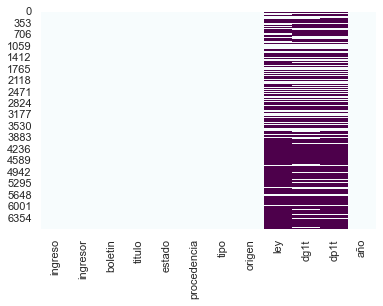

In [5]:
#Vemos datos perdidos
sns.heatmap(df.isnull(), cbar=False, cmap="BuPu")

Como se observa, tenemos datos perdidos en tres variables: *ley*, *dg1t* y *dp1t*. Esto es por la forma en la que estan construidas estas variables. Explicaremos esto con más detalle.

Para el caso de las variables *dg1t* y *dp1t*, éstas guardan la fecha en la que el proyecto ha sido discutido de manera general o particular. Las filas que no tienen información, es porque el proyecto no ha tenido discusión general o particular. Para efectos de nuestra investigación, lo que nos interesa saber no es la fecha, sino más bien si hubo o no hubo discusión general o particular. Por tanto, estas variables serán recodificadas como *dummies*, y ya no tendremos valores perdidos. Donde tenemos fecha de discusión recodificaremos como 1, y donde no hay fecha (porque no ha sido discutido) lo recodificaremos como 0.

El caso de la variable ley, sin embargo, es distinto. Esta variable identifica a qué ley está asociado cada proyecto de ley, pero *después de ser publicado*. Por tanto, esta variable está medida después del acontecimiento de nuestro vector objetivo y está altamente correlacionada con éste. Dado a lo anterior, hemos tomado la decisión de eliminar esta columna. Cabe mencionar también que esta variable no tenía un respaldo teórico importante (no es una variable que haya sido muy estudiada por la literatura científica), si la incluíamos era simplemente para contar con algo de información extra, por lo cual creemos que esto no debería afectar mayormente el rendimiento predictivo de nuestros modelos.

### Análisis y recodificación del vector objetivo

Dado que estamos frente a un problema de clasificación, nuestro vector objetivo tomará valores de 0 o 1, los cuales representarán lo siguiente:

    0 = No publicado

    1 = Publicado

Primero observemos un gráfico de nuestro vector objetivo sin recodificar:

(array([   0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

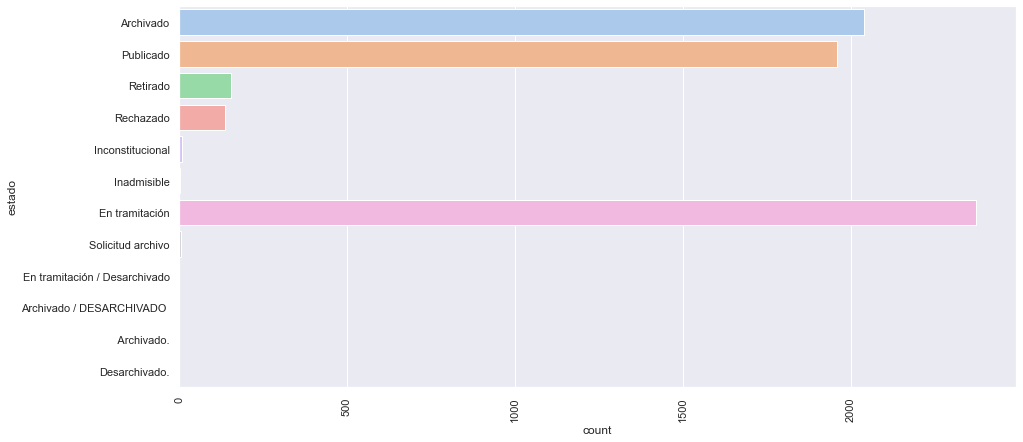

In [6]:
sns.set(rc = {'figure.figsize':(15,7)})
sns.countplot(y ='estado', data=df, palette="pastel")
plt.xticks(rotation=90)

Como se observa, la mayor parte de las leyes entran en las categorías de "Archivado", "En tramitación", y "Publicado".

In [7]:
#Hacemos un value counts para observar las frecuencias
df['estado'].value_counts()

En tramitación                   2374
Archivado                        2039
Publicado                        1958
Retirado                          155
Rechazado                         138
Inconstitucional                   10
Solicitud archivo                   6
Inadmisible                         4
En tramitación / Desarchivado       1
Archivado / DESARCHIVADO            1
 Archivado.                         1
Desarchivado.                       1
Name: estado, dtype: int64

Ahora lo recodificaremos con los valores que anteriormente hemos definido para que quede como dummy

In [8]:
df['estado'] = [1 if s == 'Publicado' else 0 for s in df['estado']]

Grafiquemos ahora nuestro vector objetivo recodificado

Text(0, 0.5, 'Publicado                 -                 No Publicado')

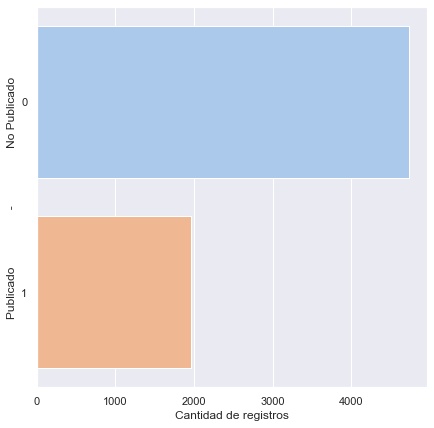

In [9]:
sns.set(rc = {'figure.figsize':(7,7)})
sns.countplot(y ='estado', data=df, palette="pastel")
plt.xlabel("Cantidad de registros")
plt.ylabel("Publicado                 -                 No Publicado")

In [10]:
#value_counts para ver las frecuencias
df['estado'].value_counts()

0    4730
1    1958
Name: estado, dtype: int64

Como se observa, tenemos 4.730 leyes no publicadas, y 1.958 leyes publicadas. El desbalance en nuestro vector objetivo es esperable dado que son muchas más las leyes que ingresan al congreso, que aquellas que son aprobadas.

A pesar de lo anterior, creemos que tenemos buenas variables explicativas y que por tanto este desbalance no va a afectar mayormente el rendimiento de nuestros modelos.

### Análisis y recodificación de variables explicativas

Veremos ahora las variables explicativas incluidas en nuestra base de datos. Comenzaremos con la columna de origen. Esta también será recodificada como dummy:

    0 = SENADO

    1 = DIPUTADOS

Primero veremos graficamente esta variable sin recodificar

<AxesSubplot:xlabel='origen', ylabel='count'>

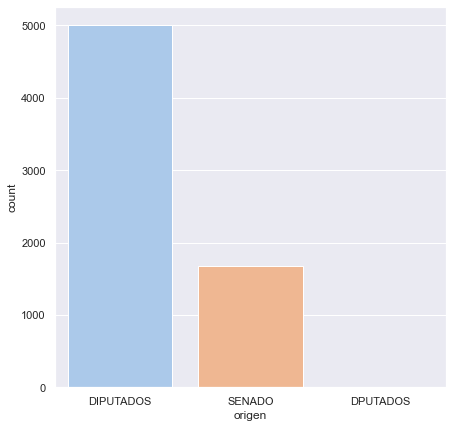

In [11]:
#Graficamos
sns.set(rc = {'figure.figsize':(7,7)})
sns.countplot(x ='origen', data=df, palette="pastel")

In [12]:
#Hacemos value_counts para ver frecuencias
df['origen'].value_counts()

DIPUTADOS    5006
SENADO       1678
DPUTADOS        1
Name: origen, dtype: int64

Como se observa, hay una ley con un pequeño error de semántica que hace que esté clasificada como "DPUTADOS" en vez de "DIPUTADOS". A continuación vamos a corregir esto para dejar todo uniforme

In [13]:
#Corregimos
df['origen'] = df['origen'].replace(['DPUTADOS'], 'DIPUTADOS')
df['origen'].value_counts()

DIPUTADOS    5007
SENADO       1678
Name: origen, dtype: int64

Solucionado esto, ahora recodificaremos como dummy, y graficaremos para chequear que todo está correcto

In [14]:
df['origen'] = [1 if s == 'DIPUTADOS' else 0 for s in df['origen']]

In [15]:
#Hacemos conteo de frecuencias para asegurar que quedó bien
df['origen'].value_counts()

1    5007
0    1681
Name: origen, dtype: int64

Text(0, 0.5, 'Cantidad de registros')

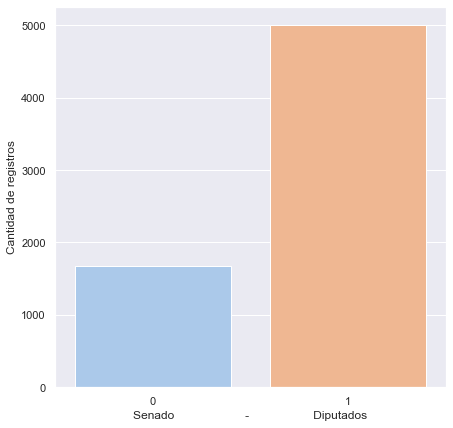

In [16]:
#Graficamos
sns.countplot(x ='origen', data=df, palette="pastel")
plt.xlabel("Senado                     -                   Diputados")
plt.ylabel("Cantidad de registros")

Como se observa, hay mucho más registros en la columna de diputados. Esto quiere decir, que generalmente cuando una ley es ingresada al congreso, es más probable que ingrese por la cámara de diputados que por la cámara del senado

Ahora veamos nuestra columna de procedencia. Esta también será recodificada como una dummy que podrá tomar los siguientes valores:

     0 = MOCION
     1 = MENSAJE

In [17]:
#Contamos frecuencias
df['procedencia'].value_counts()

MOCION     3037
MENSAJE    2084
MOCION     1567
Name: procedencia, dtype: int64

De nuevo observamos un error de semántica, esta vez dado por un espacio y que afecta a bastantes más leyes. Solucionaremos esto directamente en la transformación a dummy

In [18]:
#Transformamos y chequeamos
df['procedencia'] = [1 if s == 'MENSAJE' else 0 for s in df['procedencia']]
df['procedencia'].value_counts()

0    4604
1    2084
Name: procedencia, dtype: int64

Text(0, 0.5, 'Cantidad de registros')

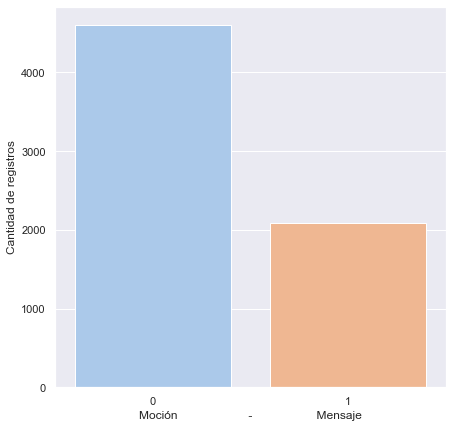

In [19]:
#Graficamos
sns.countplot(x ='procedencia', data=df, palette="pastel")
plt.xlabel("Moción                     -                   Mensaje")
plt.ylabel("Cantidad de registros")

Como se observa con nuestra variable ya recodificada, son muchas más las mociones que entran al congreso que los mensajes. Esto es completamente esperable considerando que una moción es un proyecto de ley ingresado por un legislador, y un mensaje es un proyecto de ley ingresado por el ejecutivo (presidente).

Ahora trabajaremos con la columna tipo. En esta columna tenemos nuevamente errores de semántica. Por ejemplo, para identificar una ley como "Reforma Constitucional", tenemos algunas que están catalogadas como "REFORMA CONSTITUCIONAL", otras como "Reforma Constitucional", "Reforma constitucional", "RC", etc. Lo que haremos será solucionar este problema dejando todo de la misma forma.

In [20]:
#Hacemos conteo para observar los distintos errores de semántica
df['tipo'].value_counts()

PL                        5763
PA                         540
REFORMA CONSTITUCIONAL     139
RC                         123
Reforma Constitucional      73
pl                          32
Reforma constitucional       6
pa                           6
PL                           3
LP                           2
 PL                          1
Name: tipo, dtype: int64

Recodificamos errores de sintaxis para un posterior dummies.

In [21]:
df['tipo'] = df['tipo'].replace(['LP', 'PL', 'PL ', 'pl', ' PL'], 'Proyecto_de_ley')
df['tipo'] = df['tipo'].replace(['PA', 'pa'], 'PA')
df['tipo'] = df['tipo'].replace(['RC', 'Reforma Constitucional', 'Reforma constitucional', 'REFORMA CONSTITUCIONAL'], 'Reforma_Constitucional')
df['tipo'].value_counts()

Proyecto_de_ley           5801
PA                         546
Reforma_Constitucional     341
Name: tipo, dtype: int64

Text(0.5, 0, 'Cantidad de registros')

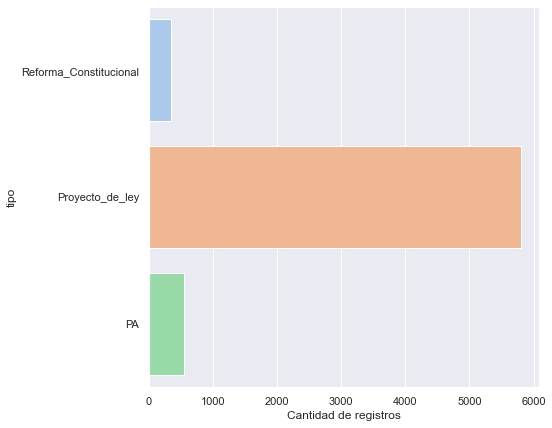

In [22]:
#Graficamos
sns.countplot(y ='tipo', data=df, palette="pastel")
plt.xlabel("Cantidad de registros")

Como se observa, ya solo tenemos las 3 categorías y sin errores de semántica. Del grafico se desprende que la mayoría de los proyectos que ingresan son proyectos de ley, en menor medida proyectos de acuerdo, y por último reformas constitucionales

Ahora vamos con las dos variables que fueron graficadas con valores perdidos: *dg1t* y *dp1t*.

La variable *dg1t* guarda la fecha donde el proyecto ha tenido discusión general del primer trámite. Reemplazamos con 1 aquellos que tuvieron discusión, y con 0 aquellos que no tuvieron discusión.

In [23]:
#Hacemos el reemplazo
df['dg1t'] = df['dg1t'].replace([np.nan], 0)

In [24]:
for i in df['dg1t']:
    if i != 0:
        df['dg1t'] = df['dg1t'].replace([i], 1)

In [25]:
#Hacemos conteo de frecuencias
df['dg1t'].value_counts()

0    4219
1    2469
Name: dg1t, dtype: int64

Aplicamos lo mismo anterior para la columna dp1t, que identifica si un proyecto tuvo discusión particular del primer trámite.

In [26]:
df['dp1t'] = df['dp1t'].replace([np.nan], 0)

In [27]:
for i in df['dp1t']:
    if i != 0:
        df['dp1t'] = df['dp1t'].replace([i], 1)

In [28]:
df['dp1t'].value_counts()

0    4529
1    2159
Name: dp1t, dtype: int64

In [29]:
#Damos un vistazo a nuestra base de datos con las recodificaciones hasta el momento
df.head()

,ingreso,ingresor,boletin,titulo,estado,procedencia,tipo,origen,ley,dg1t,dp1t,año
0,1990-03-11,3,6-07,Modifica la Constitución Politica para sancion...,0,0,Reforma_Constitucional,1,NaN,1,0,1990
1,1990-03-11,3,3-07,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,Proyecto_de_ley,1,Ley Nº 19.027,1,1,1990
2,1990-03-11,3,7-07,Interpreta disposiciones constitucionales refe...,0,0,Reforma_Constitucional,1,NaN,0,0,1990
3,1990-03-20,3,4-03,Modifica ley General de Pesca y Acuicultura.,1,1,Proyecto_de_ley,1,Ley Nº 18.977,1,1,1990
4,1990-03-20,3,5-15,Suspende la exigibilidad del Seguro de Respons...,1,1,Proyecto_de_ley,1,Ley Nº 18.976,1,1,1990


### Creación de nuevas variables

En primer lugar crearemos la variable elección, la cual identificará 4 categorías:

    No elección - 0
    Ambas - 1
    Parlamentarias - 2
    Presidenciales - 3
    
Esta variable se desprende como una variable importante desde la literatura científica. Algunos estudios sobre productividad legislativa para el caso chileno afirman que los ciclos políticos, sobre todo aquellos relacionados a las elecciones, parecieran tener capacidad explicativa sobre la productividad legislativa. Para más información sobre este punto recomendamos revisar la documentación relacionada donde se explica con más detalle.

In [30]:
#Creamos la variable
df['eleccion'] = 0 
for i in df.año:
    #Variables que tuvieron eleccion Parlamentaria y Presindencial
    if i==1993:
        df.loc[df['año'] == 1993, 'eleccion'] = '1'
    if i==2005:
        df.loc[df['año'] == 2005, 'eleccion'] = '1'
    if i==2009:
        df.loc[df['año'] == 2009, 'eleccion'] = '1'
    #Variables que tuvieron solo elecciones Parlamentarias:
    if i==1997:
        df.loc[df['año'] == 1997, 'eleccion'] = '2'
    if i==2001:
        df.loc[df['año'] == 2001, 'eleccion'] = '2'
    #Variables que tuvieron solo elecciones Presindenciales
    if i==1999:
        df.loc[df['año'] == 1999, 'eleccion'] = '3'

In [31]:
#Contamos frecuencias
df['eleccion'].value_counts()

0    5190
1     991
2     354
3     153
Name: eleccion, dtype: int64

Text(0, 0.5, 'Cantidad de registros')

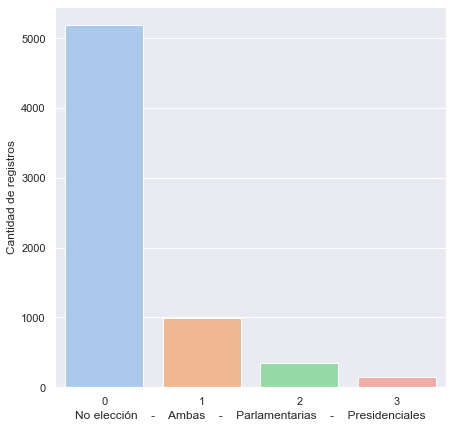

In [32]:
#Graficamos
sns.countplot(x ='eleccion', data=df, palette="pastel")
plt.xlabel("No elección    -    Ambas    -    Parlamentarias    -    Presidenciales")
plt.ylabel("Cantidad de registros")

Como es de esperar, la mayoría de los proyectos de ley son ingresados bajo años de "no elección", seguidos de años de "ambas elecciones".

In [33]:
#Chequeamos nuestra base hasta este momento
df.head()

,ingreso,ingresor,boletin,titulo,estado,procedencia,tipo,origen,ley,dg1t,dp1t,año,eleccion
0,1990-03-11,3,6-07,Modifica la Constitución Politica para sancion...,0,0,Reforma_Constitucional,1,NaN,1,0,1990,0
1,1990-03-11,3,3-07,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,Proyecto_de_ley,1,Ley Nº 19.027,1,1,1990,0
2,1990-03-11,3,7-07,Interpreta disposiciones constitucionales refe...,0,0,Reforma_Constitucional,1,NaN,0,0,1990,0
3,1990-03-20,3,4-03,Modifica ley General de Pesca y Acuicultura.,1,1,Proyecto_de_ley,1,Ley Nº 18.977,1,1,1990,0
4,1990-03-20,3,5-15,Suspende la exigibilidad del Seguro de Respons...,1,1,Proyecto_de_ley,1,Ley Nº 18.976,1,1,1990,0


Ahora crearemos la variable de honeymoon, la cual también tiene sustento en la literatura científica. Se afirma que los primeros seis meses de un gobierno (llamado período de “luna de miel”), impacta significativamente y positivamente en la productividad legislativa. Por tanto, crearemos una variable *dummy* que identifica estos períodos.

In [34]:
#Creamos la variable
df['honeymoon']=0

for i in df.año:
    df.loc[(df['año']==1990) & (df['ingresor']>2) & (df['ingresor']<9) & (df['procedencia']==1),'honeymoon'] = '1'
    df.loc[(df['año']==1994) & (df['ingresor']>2) & (df['ingresor']<9) & (df['procedencia']==1),'honeymoon'] = '1'
    df.loc[(df['año']==2000) & (df['ingresor']>2) & (df['ingresor']<9) & (df['procedencia']==1),'honeymoon'] = '1'
    df.loc[(df['año']==2006) & (df['ingresor']>2) & (df['ingresor']<9) & (df['procedencia']==1),'honeymoon'] = '1'

In [35]:
#Nos aseguramos que quede como int
df['honeymoon'] = df['honeymoon'].astype(int)

In [36]:
#Hacemos conteo de frecuencias
df['honeymoon'].value_counts()

0    6444
1     244
Name: honeymoon, dtype: int64

Text(0, 0.5, 'Cantidad de registros')

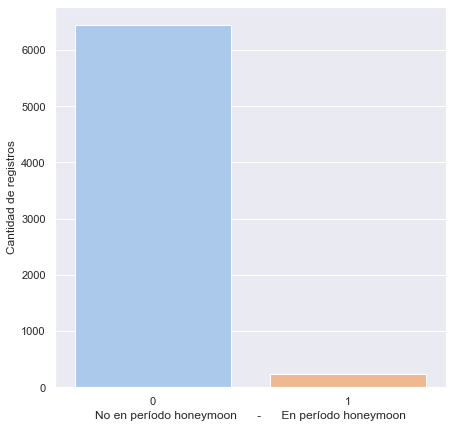

In [37]:
#Graficamos
sns.countplot(x ='honeymoon', data=df, palette="pastel")
plt.xlabel("No en período honeymoon      -      En período honeymoon")
plt.ylabel("Cantidad de registros")

Como se observa con nuestra variable ya creada, son pocos los proyectos que han sido categorizados como *honeymoon*. Esto es esperable porque para que un proyecto sea considerado como *honeymoon* debe cumplir varias características: tiene que ser un mensaje (proyecto enviado por el presidente), y además ser enviado dentro de los primeros seis meses de gobierno.

Con todas las variables ya creadas, haremos otra vez un chequeo de datos perdidos.

In [38]:
df.isnull().sum()

ingreso           0
ingresor          0
boletin           0
titulo            0
estado            0
procedencia       0
tipo              0
origen            0
ley            4749
dg1t              0
dp1t              0
año               0
eleccion          0
honeymoon         0
dtype: int64

Tal como muestra la tabla, solo tenemos valores perdidos en la variable ley. Quitaremos esta columna dado que no la utilizaremos en nuestros modelos por las razones que explicamos anteriormente.

In [39]:
#Eliminamos la columna
df = df.drop(['ley'], axis=1)

In [40]:
#Chequeamos nuestra base
df.head()

,ingreso,ingresor,boletin,titulo,estado,procedencia,tipo,origen,dg1t,dp1t,año,eleccion,honeymoon
0,1990-03-11,3,6-07,Modifica la Constitución Politica para sancion...,0,0,Reforma_Constitucional,1,1,0,1990,0,0
1,1990-03-11,3,3-07,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,Proyecto_de_ley,1,1,1,1990,0,1
2,1990-03-11,3,7-07,Interpreta disposiciones constitucionales refe...,0,0,Reforma_Constitucional,1,0,0,1990,0,0
3,1990-03-20,3,4-03,Modifica ley General de Pesca y Acuicultura.,1,1,Proyecto_de_ley,1,1,1,1990,0,1
4,1990-03-20,3,5-15,Suspende la exigibilidad del Seguro de Respons...,1,1,Proyecto_de_ley,1,1,1,1990,0,1


Nuestra base ya no tiene valores perdidos o nulos y tiene todas las variables que necesitaremos ya creadas.

### Análisis de correlaciones

Haremos un análisis de correlaciones simplemente para asegurarnos que no existen correlaciones extremadamente fuertes entre variables o con nuestro vector objetivo

In [41]:
#Hacemos matriz
corr_matrix = df.corr()
df.corr()

,ingresor,estado,procedencia,origen,dg1t,dp1t,año,honeymoon
ingresor,1.000000,-0.005076,-0.000310,-0.016673,-0.013743,-0.010376,0.043358,-0.061792
estado,-0.005076,1.000000,0.648385,0.047825,0.655837,0.683069,-0.338555,0.209553
procedencia,-0.000310,0.648385,1.000000,0.096604,0.528932,0.527700,-0.309047,0.289225
origen,-0.016673,0.047825,0.096604,1.000000,-0.028162,0.028497,0.008230,-0.008589
dg1t,-0.013743,0.655837,0.528932,-0.028162,1.000000,0.891943,-0.237032,0.183307
dp1t,-0.010376,0.683069,0.527700,0.028497,0.891943,1.000000,-0.183903,0.184610
año,0.043358,-0.338555,-0.309047,0.008230,-0.237032,-0.183903,1.000000,-0.170722
honeymoon,-0.061792,0.209553,0.289225,-0.008589,0.183307,0.184610,-0.170722,1.000000


Para poder observar esto de mejor manera, lo visualizaremos en un heatmap

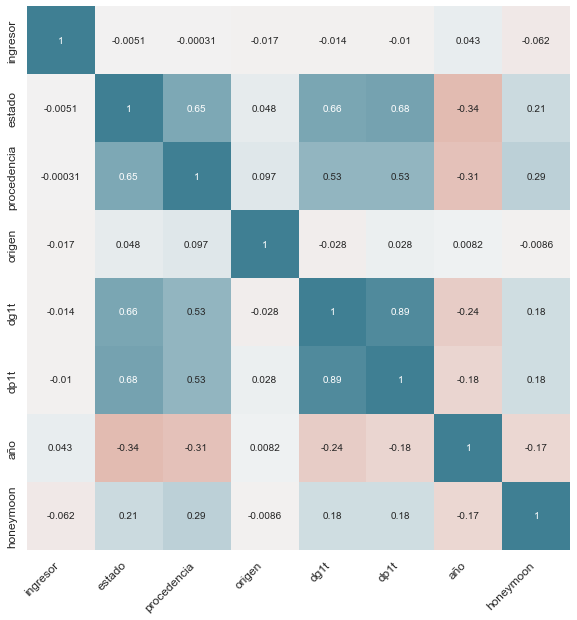

In [42]:
#Heatmap matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 12)

Como se observa, ninguna de las variables explicativas presenta una fuerte correlación con nuestro vector objetivo. Si observamos que las variables *dg1t* y *dp1t* tienen una correlación bastante alta entre ellas. En parte, esto es esperable dado que la variable *dp1t* está relacionada a *dg1t* considerando que un proyecto no puede tener discusión particular sin haber tenido antes discusión general y creeemos que por esta razón se presenta esta correlación.

Teniendo también en cuenta lo anterior, cuando entrenemos los modelos discutiremos si es posible entrenar un nuevo modelo que tenga un rendimiento similar, sin considerar estas dos variables dado que esto también nos presenta una ventaja práctica. Gracias a que incluimos estas dos variables, nuestro modelo está pensado para predecir proyectos de ley que han sido ingresados al mes y medio/dos meses desde que son ingresados. Sin embargo, si logramos obtener un buen modelo sin considerar estas dos variables, nuestro modelo funcionaría incluso inmediatamente luego que un proyecto sea ingresado, lo que sería una ventaja interesante. Discutiremos esto con más detalle más adelante.

### Creación de dummies

Para finalizar el preprocesamiento de las variables que tenemos hasta este momento, ahora convertiremos nuestras variables categóricas a dummies

In [43]:
#Convertimos la variable tipo
for serie in ['tipo']:
    dummy=pd.get_dummies(df[serie],prefix=serie).astype('int32')
    df=pd.concat([df,dummy],axis=1).drop(serie,1)

C:\Users\MACKAR~1\AppData\Local\Temp/ipykernel_17236/2393065453.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df=pd.concat([df,dummy],axis=1).drop(serie,1)


In [44]:
#Chequeamos
df.head()

,ingreso,ingresor,boletin,titulo,estado,procedencia,origen,dg1t,dp1t,año,eleccion,honeymoon,tipo_PA,tipo_Proyecto_de_ley,tipo_Reforma_Constitucional
0,1990-03-11,3,6-07,Modifica la Constitución Politica para sancion...,0,0,1,1,0,1990,0,0,0,0,1
1,1990-03-11,3,3-07,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,1,1,1,1990,0,1,0,1,0
2,1990-03-11,3,7-07,Interpreta disposiciones constitucionales refe...,0,0,1,0,0,1990,0,0,0,0,1
3,1990-03-20,3,4-03,Modifica ley General de Pesca y Acuicultura.,1,1,1,1,1,1990,0,1,0,1,0
4,1990-03-20,3,5-15,Suspende la exigibilidad del Seguro de Respons...,1,1,1,1,1,1990,0,1,0,1,0


In [45]:
#Convertimos la variable elección
for serie in ['eleccion']:
    dummy=pd.get_dummies(df[serie],prefix=serie).astype('int32')
    df=pd.concat([df,dummy],axis=1).drop(serie,1)

C:\Users\MACKAR~1\AppData\Local\Temp/ipykernel_17236/3957871377.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df=pd.concat([df,dummy],axis=1).drop(serie,1)


In [46]:
#Chequeamos
df.head()

,ingreso,ingresor,boletin,titulo,estado,procedencia,origen,dg1t,dp1t,año,honeymoon,tipo_PA,tipo_Proyecto_de_ley,tipo_Reforma_Constitucional,eleccion_0,eleccion_1,eleccion_2,eleccion_3
0,1990-03-11,3,6-07,Modifica la Constitución Politica para sancion...,0,0,1,1,0,1990,0,0,0,1,1,0,0,0
1,1990-03-11,3,3-07,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,1,1,1,1990,1,0,1,0,1,0,0,0
2,1990-03-11,3,7-07,Interpreta disposiciones constitucionales refe...,0,0,1,0,0,1990,0,0,0,1,1,0,0,0
3,1990-03-20,3,4-03,Modifica ley General de Pesca y Acuicultura.,1,1,1,1,1,1990,1,0,1,0,1,0,0,0
4,1990-03-20,3,5-15,Suspende la exigibilidad del Seguro de Respons...,1,1,1,1,1,1990,1,0,1,0,1,0,0,0


In [47]:
#Nos aseguramos que todas las variables sean int
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6688 entries, 0 to 6687
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ingreso                      6688 non-null   datetime64[ns]
 1   ingresor                     6688 non-null   int64         
 2   boletin                      6688 non-null   object        
 3   titulo                       6688 non-null   object        
 4   estado                       6688 non-null   int64         
 5   procedencia                  6688 non-null   int64         
 6   origen                       6688 non-null   int64         
 7   dg1t                         6688 non-null   int64         
 8   dp1t                         6688 non-null   int64         
 9   año                          6688 non-null   int64         
 10  honeymoon                    6688 non-null   int32         
 11  tipo_PA                      6688 non-null 

Con nuestras *dummies* creadas, ahora eliminaremos las columnas que son simplemente informativas, las de ingreso y boletín, dado que no las ocuparemos en nuestro modelo

In [48]:
#Eliminamos estas columnas
df = df.drop(['ingreso', 'boletin'], axis=1)

In [49]:
#Chequeamos
df.head()

,ingresor,titulo,estado,procedencia,origen,dg1t,dp1t,año,honeymoon,tipo_PA,tipo_Proyecto_de_ley,tipo_Reforma_Constitucional,eleccion_0,eleccion_1,eleccion_2,eleccion_3
0,3,Modifica la Constitución Politica para sancion...,0,0,1,1,0,1990,0,0,0,1,1,0,0,0
1,3,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,1,1,1,1990,1,0,1,0,1,0,0,0
2,3,Interpreta disposiciones constitucionales refe...,0,0,1,0,0,1990,0,0,0,1,1,0,0,0
3,3,Modifica ley General de Pesca y Acuicultura.,1,1,1,1,1,1990,1,0,1,0,1,0,0,0
4,3,Suspende la exigibilidad del Seguro de Respons...,1,1,1,1,1,1990,1,0,1,0,1,0,0,0


Por último, un paso importante será renombrar todas las variables. Les agregaremos a cada una el sufijo *df* para que cuando hagamos el procesamiento del texto y tengamos una columna por cada palabra, evitemos tener columnas con los mismos nombres

In [50]:
#Renombramos
df = df.rename(columns={"estado": "estadodf", "tipo": "tipodf", 'procedencia':'procendenciadf',
                                'origen':'origendf', 'ingresor':'ingresordf', 'honeymoon':'honeymoondf',
                               'eleccion':'elecciondf', 'dg1t':'dg1tdf', 'dp1t':'dp1tdf', 'año':'añodf'})

In [51]:
#Chequeamos que todas las variables han sido renombradas
df.head()

,ingresordf,titulo,estadodf,procendenciadf,origendf,dg1tdf,dp1tdf,añodf,honeymoondf,tipo_PA,tipo_Proyecto_de_ley,tipo_Reforma_Constitucional,eleccion_0,eleccion_1,eleccion_2,eleccion_3
0,3,Modifica la Constitución Politica para sancion...,0,0,1,1,0,1990,0,0,0,1,1,0,0,0
1,3,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,1,1,1,1990,1,0,1,0,1,0,0,0
2,3,Interpreta disposiciones constitucionales refe...,0,0,1,0,0,1990,0,0,0,1,1,0,0,0
3,3,Modifica ley General de Pesca y Acuicultura.,1,1,1,1,1,1990,1,0,1,0,1,0,0,0
4,3,Suspende la exigibilidad del Seguro de Respons...,1,1,1,1,1,1990,1,0,1,0,1,0,0,0


Ahora nuestro dataset está listo para aplicar el procesamiento del texto a la variable título

### Procesamiento de texto

Para el procesamiento del texto, comenzaremos creando una columna igual a nuestra columna de título, pasaremos todo a *lower* y le aplicaremos una función de limpieza que lo que hace es limpiar caracteres especiales, quitar links de páginas si es que los hubiera y eliminar algunas palabras con menos de 2 carácteres. Esta función se encuentra en nuestro archivo de funciones

In [52]:
#Aplicamos y chequeamos
df['Titulos_Procesados'] = df['titulo'].str.lower().apply(lambda x: func.limpieza(x))
df.head()

,ingresordf,titulo,estadodf,procendenciadf,origendf,dg1tdf,dp1tdf,añodf,honeymoondf,tipo_PA,tipo_Proyecto_de_ley,tipo_Reforma_Constitucional,eleccion_0,eleccion_1,eleccion_2,eleccion_3,Titulos_Procesados
0,3,Modifica la Constitución Politica para sancion...,0,0,1,1,0,1990,0,0,0,1,1,0,0,0,"[modifica, constitución, politica, para, sanci..."
1,3,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,1,1,1,1990,1,0,1,0,1,0,0,0,"[modifica, ley, 314, sobre, conductas, terrori..."
2,3,Interpreta disposiciones constitucionales refe...,0,0,1,0,0,1990,0,0,0,1,1,0,0,0,"[interpreta, disposiciones, constitucionales, ..."
3,3,Modifica ley General de Pesca y Acuicultura.,1,1,1,1,1,1990,1,0,1,0,1,0,0,0,"[modifica, ley, general, pesca, acuicultura]"
4,3,Suspende la exigibilidad del Seguro de Respons...,1,1,1,1,1,1990,1,0,1,0,1,0,0,0,"[suspende, exigibilidad, del, seguro, responsa..."


Lo que haremos ahora será eliminar palabras comunes con stopwords, esto lo haremos con la librería nltk

In [53]:
#Importamos nltk para comenzar a eliminar palabras comunes con stopwords.
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mackarena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mackarena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
stops = set(stopwords.words('spanish'))
print(stops)
#Esta es la lista de stopwords que tenemos disponible desde nltk

{'fueras', 'pero', 'hubieses', 'un', 'habiendo', 'desde', 'cual', 'tenías', 'hubieran', 'todos', 'habremos', 'yo', 'suyas', 'tuviesen', 'estuvieseis', 'estuvierais', 'en', 'hubierais', 'habíais', 'sois', 'estado', 'hubiste', 'tendré', 'seréis', 'mías', 'nada', 'vuestra', 'tuvo', 'tuvisteis', 'estarán', 'estarían', 'tuviésemos', 'algunas', 'se', 'serías', 'cuando', 'tuyas', 'hasta', 'está', 'hubimos', 'estos', 'estando', 'quienes', 'habrán', 'esa', 'habían', 'mío', 'fuese', 'estas', 'haya', 'estuviesen', 'hubiese', 'sentido', 'que', 'habríamos', 'hayan', 'habrían', 'nos', 'fuesen', 'estará', 'otras', 'vuestros', 'mía', 'sentidas', 'por', 'tengan', 'fui', 'tiene', 'mis', 'porque', 'tendría', 'vosotros', 'al', 'fue', 'tuyo', 'mí', 'muy', 'contra', 'habíamos', 'están', 'había', 'del', 'ante', 'otros', 'míos', 'otra', 'estuvimos', 'tendrían', 'habrías', 'tengo', 'para', 'suya', 'estamos', 'estados', 'sea', 'habrá', 'tienen', 'suyo', 'tenga', 'estábamos', 'estuve', 'tengáis', 'sus', 'hubiéra

In [55]:
def do_nothing(tokens):
    return tokens

#Para usar CountVectorizer con datos ya Tokenizados, se agrega una funcion donde salte ese paso:
vectorizer_count = CountVectorizer(stop_words=stops, max_features=1000, lowercase=False, preprocessor=None, tokenizer=do_nothing)
vectorizer = vectorizer_count.fit_transform(df['Titulos_Procesados'])

C:\Users\Mackarena\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'á', 'é', 'í', 'ú'] not in stop_words.
  warnings.warn(


Preparamos un dataframe donde cada columna sea una palabra y contabilice la frecuencia

In [56]:
words = vectorizer_count.get_feature_names()
#Lo pasamos a dataframe donde cada columna sea una palabra y contabilice su frecuencia
dfwords = pd.DataFrame(vectorizer.toarray(), columns=words)

C:\Users\Mackarena\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Lo primero que haremos será ver la frecuencia de palabras. Veremos las 20 palabras con más frecuencia

In [57]:
#Haremos un dataframe simplemente para ver qué palabras tienen mayor cantidad de frecuencias
words_freq=vectorizer.toarray().sum(axis=0)
words_freq
#Veremos las 20 palabras con más frecuencia
w = {'words':words,'frequency':words_freq}
dfwords1 = pd.DataFrame(w)

dfwords_top = dfwords1.sort_values(by='frequency', ascending=False).head(20)

In [58]:
dfwords_top

,words,frequency
623,modifica,2485
573,ley,2453
393,establece,873
116,artículo,748
277,código,740
796,proyecto,703
862,república,590
181,chile,570
239,constitucional,566
508,indica,536


Dentro de las palabras con más frecuencia se encuentra "modifica", "ley", "establece", "artículo", entre otras. Esto tiene mucho sentido dado que estamos hablando de títulos de proyectos de ley

Por ultimo, lo que haremos será concatenar este dataframe creado con las palabras, a nuestro dataframe principal que tiene nuestras variables explicativas

In [59]:
#Concatenamos
finaldf = pd.concat([df, dfwords], axis=1)
finaldf.head()

,ingresordf,titulo,estadodf,procendenciadf,origendf,dg1tdf,dp1tdf,añodf,honeymoondf,tipo_PA,...,vivienda,viviendas,votaciones,vías,víctimas,zona,zonas,ámbito,áreas,órganos
0,3,Modifica la Constitución Politica para sancion...,0,0,1,1,0,1990,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,1,1,1,1990,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Interpreta disposiciones constitucionales refe...,0,0,1,0,0,1990,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Modifica ley General de Pesca y Acuicultura.,1,1,1,1,1,1990,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,Suspende la exigibilidad del Seguro de Respons...,1,1,1,1,1,1990,1,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
#Guardamos ya que lo necesitaremos para la última parte de este documento
finaldf.to_excel('finaldf.xlsx', sheet_name='sheet1', index=False)

Con nuestro dataframe ya listo, lo que haremos simplemente para hacer los procesos de modelamiento más ordenados, es separar un dataframe que solo va a contener nuestro vector objetivo, y otro dataframe que solo va a contener nuestras variables explicativas

In [61]:
#Separamos nuestro vector objetivo en finaldfvo
finaldfvo = finaldf['estadodf']

In [62]:
#De nuestro finaldf eliminamos nuestro vector objetivo + las variables de título que ya procesamos con el countvectorizer
finaldf = finaldf.drop(['estadodf', 'titulo', 'Titulos_Procesados'], axis=1)

In [63]:
#Chequeamos como quedó
finaldf.head()

,ingresordf,procendenciadf,origendf,dg1tdf,dp1tdf,añodf,honeymoondf,tipo_PA,tipo_Proyecto_de_ley,tipo_Reforma_Constitucional,...,vivienda,viviendas,votaciones,vías,víctimas,zona,zonas,ámbito,áreas,órganos
0,3,0,1,1,0,1990,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1,1,1,1,1990,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,1990,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,1,1,1990,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1,1,1,1,1990,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Con esto, ya tenemos todo listo para comenzar el modelamiento

## Implementación

En esta sección definiremos los conjuntos de entrenamiento y validación, entrenaremos los modelos y los evaluaremos

### Definición de conjuntos de entrenamiento y validación

Ocuparemos un 25% de la muestra como conjunto de pruebas, y utilizaremos una semilla aleatoria para asegurar replicabilidad

In [64]:
#Definimos conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(finaldf,
                                                    finaldfvo,
                                                    test_size=.25,
                                                    random_state=11238)

In [65]:
#Comprobamos
X_test.shape[0]/finaldf.shape[0]

0.25

Como se observa, efectivamente se está utilizando un 25% como conjunto de pruebas

### Entrenamiento y evaluación de modelos

Con nuestros conjuntos de entrenamiento y pruebas listos, pasaremos a entrenar algunos modelos. En esta primera instancia no haremos modificación de parámetros. Hemos pensado en primera instancia entrenar un modelo de Análisis Lineal Discriminante.

Creemos que un modelo ADL puede tener buen rendimiento por la forma en la que trabaja. Como estamos convencidos que nuestras variables explicativas son bastante buenas, considerando que en este modelo la ocurrencia de una clase se evalúa en función a una frontera de decisión (ver img), es decir, lo que hace es "discriminar", generar una serie de lineas de division o fronteras de división entre cada una de las clases maximizando esta separación, creemos que el modelo debería ser capaz de definir esta frontera con buena precisión al tener buenas variables explicativas.

<img src=https://media.geeksforgeeks.org/wp-content/uploads/20190423124957/2dldanew.jpg>

Veamos como es el rendimiento de este modelo con nuestros datos

In [66]:
modelo_lda = LinearDiscriminantAnalysis()

In [67]:
modelo_lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [68]:
#Para evaluar el desempeño guardaremos las predicciones de clases
lda_class_pred = modelo_lda.predict(X_test)

In [69]:
#Hacemos el classification report para ver métricas
print(classification_report(y_test, lda_class_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1189
           1       0.78      0.82      0.80       483

    accuracy                           0.88      1672
   macro avg       0.85      0.86      0.86      1672
weighted avg       0.88      0.88      0.88      1672



Como se observa, las métricas en esta primera instancia resultan bastante buenas. Tenemos un 0.78 de precisión para la clase 1, con un recall de 0.82 y un accuracy de 0.88.

Ahora probaremos un modelo Gradient Boosting por las ventajas que presenta. Como se trata de un modelo que va aprendiendo de manera secuencial y de los mismos errores que va cometiendo en cada iteración, creemos que también puede aprender bastante bien a clasificar nuestro vector objetivo dadas las variables explicativas que tenemos, y por ende tener también un muy buen rendimiento.

<img src=https://isglobal-brge.github.io/Aprendizaje_Automatico_1/figures/boosted-trees-process.png>

In [70]:
modelo_gb = GradientBoostingClassifier()

In [71]:
modelo_gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [72]:
#Para evaluar el desempeño guardaremos las predicciones de clases
gb_class_pred = modelo_gb.predict(X_test)

In [73]:
#Hacemos el classification report para ver métricas
print(classification_report(y_test, gb_class_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1189
           1       0.79      0.88      0.83       483

    accuracy                           0.90      1672
   macro avg       0.87      0.89      0.88      1672
weighted avg       0.90      0.90      0.90      1672



Como se observa, nuestro modelo Gradient Boosting tiene un poco más de precisión para la clase 1 que nuestro modelo ADL y un mejor recall y accuracy

Por último como tercer modelo probaremos un Random Forest también dadas sus ventajas al ser un modelo ensamblador. Lo que hacen este tipo de modelos es formarse a partir de un grupo de modelos predictivos, lo que les permite alcanzar mejor precisión y rendimiento. La forma de trabajar es que cada “árbol” da una clasificación; el resultado es la clase con mayor número de votos. Creemos que este modelo puede funcionar bien con nuestros datos dado que los modelos de *Random Forest* son bastante populares por desempeñarse bastante bien generalmente independiente del problema, además de que se pueden utilizar en problemas de regresión o clasificación
<img src=https://www.iartificial.net/wp-content/uploads/2019/06/Random-Forest-Bagging.png>

In [74]:
modelo_rf = RandomForestClassifier()

In [75]:
modelo_rf.fit(X_train, y_train)

RandomForestClassifier()

In [76]:
rf_class_pred = modelo_rf.predict(X_test)

In [77]:
print(classification_report(y_test, rf_class_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1189
           1       0.81      0.86      0.84       483

    accuracy                           0.90      1672
   macro avg       0.88      0.89      0.88      1672
weighted avg       0.91      0.90      0.90      1672



Como se observa, nuestro modelo Random Forest tiene también un rendimiento excelente. Tenemos una precisión de 0.81 para la clase 1 (mayor que el modelo ADL y GB), mientras que el recall está por sobre el modelo ADL pero bajo el modelo GB. Respecto al accuracy este es el mismo que el del modelo Gradient Boosting.

Con los tres modelos entrenados, graficaremos una curva ROC para también evaluar los modelos bajo esta métrica. La curva ROC muestra la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos del modelo. Por tanto, mientras más hacia la izquierda superior esté la curva ROC, nuestro modelo será mejor.

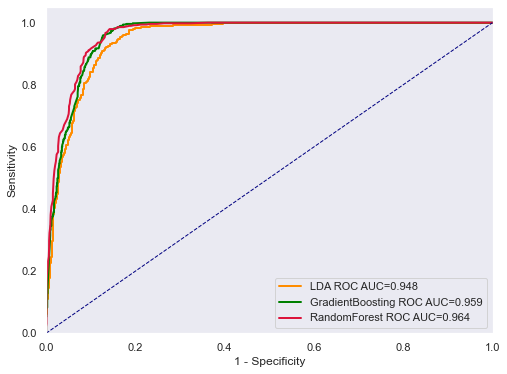

In [78]:
lda_prediction_proba = modelo_lda.predict_proba(X_test)[:, 1]
gb_prediction_proba = modelo_gb.predict_proba(X_test)[:, 1]
rf_prediction_proba = modelo_rf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()
fpr, tpr, _ = roc_curve(y_test.ravel(), lda_prediction_proba.ravel())
roc_auc = roc_auc_score(y_test.ravel(), lda_prediction_proba.ravel())
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='LDA ROC AUC={0:.3f}'.format(roc_auc))

fpr, tpr, _ = roc_curve(y_test.ravel(), gb_prediction_proba.ravel())
roc_auc = roc_auc_score(y_test.ravel(), gb_prediction_proba.ravel())
plt.plot(fpr, tpr, color='green', lw=2,
         label='GradientBoosting ROC AUC={0:.3f}'.format(roc_auc))

fpr, tpr, _ = roc_curve(y_test.ravel(), rf_prediction_proba.ravel())
roc_auc = roc_auc_score(y_test.ravel(), rf_prediction_proba.ravel())
plt.plot(fpr, tpr, color='crimson', lw=2,
         label='RandomForest ROC AUC={0:.3f}'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

En conclusión, los tres modelos entrenados cuentan con métricas bastante buenas y tienen buen rendimiento predictivo. Sin embargo, tanto *Gradient Boosting* como *Random Forest* están un poco por sobre el modelo LDA.

### Serialización

Con lo anterior, podemos concluir que hasta el momento los dos modelos que tiene mejor rendimiento considerando sobre todo el *recall* y la *precisión* son los modelos de *Gradient Boosting* y *Random Forest*. Por tanto, pasaremos a serializar estos modelos.

In [79]:
pkl.dump(modelo_gb, open('modelo_gradientboosting.pkl', 'wb'))

In [80]:
pkl.dump(modelo_rf, open('modelo_randomforest.pkl', 'wb'))

## Ajustes al modelo y discusión

En esta sección se discutirán algunos pequeños ajustes al modelo que nos permitan contar con ciertas ventajas frente a los modelos ya presentados.

Anteriormente hemos observado que si bien nuestros tres modelos tienen buen rendimiento predictivo, los dos mejores modelos hasta el momento son Random Forest y Gradient Boosting. En esta sección la tarea es evaluar estos dos modelos pero considerando algunos ajustes. Principalmente, lo que haremos será entrenar dos modelos (Gradient Boosting y Random Forest), esta vez sin considerar las variables dg1t y dp1t, debido a que queremos poner a prueba hasta qué punto sin estas variables podemos obtener también modelos con buenos resultados y segundo, porque de todas nuestras variables estas dos eran las que presentaban más correlación entre ellas. Si logramos obtener un modelo con buen rendimiento sin considerar estas dos variables, nuestro modelo no solo funcionaría para predecir al mes y medio/dos meses desde que un proyecto es presentado, sino que su predicción podría ser casi automática desde el momento que el proyecto es presentado, lo que sin duda aumentaría significativamente su impacto.

Para poner a prueba lo anterior, lo primero que haremos será importar el finaldf que hemos guardado anteriormente

In [81]:
dfajustado = pd.read_excel('finaldf.xlsx', sheet_name='sheet1')
dfajustado.head()

,ingresordf,titulo,estadodf,procendenciadf,origendf,dg1tdf,dp1tdf,añodf,honeymoondf,tipo_PA,...,vivienda,viviendas,votaciones,vías,víctimas,zona,zonas,ámbito,áreas,órganos
0,3,Modifica la Constitución Politica para sancion...,0,0,1,1,0,1990,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,"Modifica la Ley Nº 18.314, sobre Conductas Ter...",1,1,1,1,1,1990,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Interpreta disposiciones constitucionales refe...,0,0,1,0,0,1990,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Modifica ley General de Pesca y Acuicultura.,1,1,1,1,1,1990,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3,Suspende la exigibilidad del Seguro de Respons...,1,1,1,1,1,1990,1,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
#Separamos nuestro vector objetivo
dfajustado_vo = dfajustado['estadodf']

Ahora eliminaremos las columnas dg1t y dp1t

In [83]:
#Eliminamos las columnas que no utilizaremos
dfajustado = dfajustado.drop(['estadodf', 'titulo', 'Titulos_Procesados', 'dg1tdf', 'dp1tdf'], axis=1)

Al igual que para los modelos anteriores, ocuparemos un 25% de la muestra como conjunto de pruebas, y utilizaremos una semilla aleatoria para asegurar replicabilidad

In [84]:
#Definimos conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(dfajustado,
                                                    dfajustado_vo,
                                                    test_size=.25,
                                                    random_state=11238)

Ahora entrenaremos los modelos y veremos las métricas

In [85]:
modelo_gb_ajustado = GradientBoostingClassifier()
modelo_gb_ajustado.fit(X_train, y_train)

GradientBoostingClassifier()

In [86]:
gb_class_pred_ajustado = modelo_gb_ajustado.predict(X_test)
print(classification_report(y_test, gb_class_pred_ajustado))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1189
           1       0.78      0.76      0.77       483

    accuracy                           0.87      1672
   macro avg       0.84      0.83      0.84      1672
weighted avg       0.87      0.87      0.87      1672



In [87]:
modelo_rf_ajustado = RandomForestClassifier()
modelo_rf_ajustado.fit(X_train, y_train)

RandomForestClassifier()

In [88]:
rf_class_pred_ajustado = modelo_rf_ajustado.predict(X_test)
print(classification_report(y_test, rf_class_pred_ajustado))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1189
           1       0.79      0.73      0.76       483

    accuracy                           0.87      1672
   macro avg       0.84      0.83      0.83      1672
weighted avg       0.86      0.87      0.86      1672



In [89]:
pkl.dump(modelo_gb_ajustado, open('modelo_gradientboosting_ajustado.pkl', 'wb'))

In [90]:
pkl.dump(modelo_rf_ajustado, open('modelo_randomforest_ajustado.pkl', 'wb'))

Como se observa, al quitar estas dos variables el rendimiento predictivo baja un poco pero bastante sutilmente. Creemos entonces que estos modelos son valiosos porque a diferencia de los dos anteriores, con estos modelos no contamos con la brecha de tiempo que necesitamos esperar para poder someter un proyecto a la predicción, por lo cual puede ser un buen comienzo para obtener información valiosa al mismo momento que un proyecto es presentado.

En suma, respecto de los modelos predictivos para utilizar al mes y medio/dos meses desde que un proyecto es ingresado, concluimos que nuestro modelo Random Forest es el mejor. Esto porque tiene mejores métricas de precisión pero sobre todo, porque es el que presenta mejores métricas respecto al F1, el cual es una medida que combina tanto precisión como recall por ende creemos que esta medida es la adecuada para discriminar entre un modelo u otro.

Respecto a los modelos ajustados, los cuales pueden ser utilizados desde el mismo momento en que la ley es ingresada, el mejor modelo resulta ser el Gradient Boosting, considerando los mismos criterios de evaluación anterior. Este modelo si bien tiene un 0.01 menos de precisión que el modelo Random Forest, tiene mejor recall y mejor F1.


## Conclusiones

En esta sección se presentaran las conclusiones generales y se discutirá sobre los aspectos que puede ser posible mejorar en un futuro para obtener mejores resultados que los ya obtenidos.

El objetivo del presente proyecto fue predecir si un proyecto de ley tiene chances de ser aprobado o no a partir de variables como tipo, origen, título, procedencia, elección, honeymoon, discusión general y discusión particular. Para ello se desarrolló un modelo de machine learning a partir de una base de datos que contenía todas las leyes presentadas al congreso chileno desde el año 1990 al 2009.

Los modelos evaluados, los cuales fueron LDA, Gradient Boosting y Random Forest, lograron predecir si un proyecto tiene chances de ser aprobado con una precisión mayor al 0.75, tomando en cuenta las variables anteriormente señaladas. Con ello, nuestra hipótesis ha sido corroborada. El mejor modelo fue el modelo Random Forest el cual tuvo una precisión de 0.81, mientras que el mejor modelo ajustado fue el Gradient Boosting, con una precisión de 0.78. Además del objetivo que nos planteamos al comienzo, también logramos obtener un modelo con buen rendimiento que pueda ser utilizado al mismo momento en que la ley es presentada.

Respecto a las proyecciones a futuro, un siguiente paso podría considerar la validación del modelo con datos que consideren los últimos años de productividad legislativa. Además de ello, se podría realizar un clustering de leyes según el texto, de tal forma de relacionar los resultados con una temática legislativa en particular. Por último, creemos importante desarrollar entornos de ejecución amigables (web o app), en el cual las instituciones públicas puedan acceder a estas predicciones de una manera más sencilla.
